In [98]:
!nvidia-smi

Sat Aug 28 05:30:38 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P0    58W / 149W |   2923MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [99]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
from torchvision import datasets
from torch.utils.data import DataLoader

## 1. 设置设备（cpu 或 gpu）

In [100]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## 2. 定义一些变量

In [101]:
batch_size = 32
lr = 2e-3
n_epochs = 20

## 3.数据加载

In [122]:
transform=torchvision.transforms.Compose([torchvision.transforms.Resize((224,224)), 
                                          torchvision.transforms.ToTensor(), 
                                          torchvision.transforms.Normalize([0.5], [0.5])])
train_dataset = datasets.FashionMNIST(root='data',
                               train=True,
                               transform=transform,
                               download=True)
test_dataset = datasets.FashionMNIST(root='data',
                               train=False,
                               transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')


In [103]:
for i, data in enumerate(train_loader):
  inputs, labels = data
  print(inputs.shape)
  print(labels.shape)
  print(labels)
  break

torch.Size([32, 1, 224, 224])
torch.Size([32])
tensor([9, 2, 1, 1, 6, 1, 4, 6, 5, 7, 4, 5, 7, 3, 4, 1, 2, 4, 8, 0, 2, 5, 7, 9,
        1, 4, 6, 0, 9, 3, 8, 8])


Text(0.5, 0.98, 'MNIST Dataset - preview')

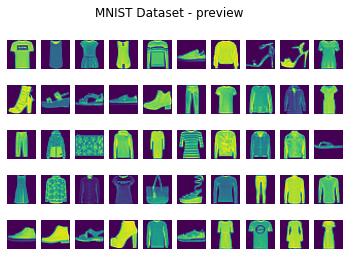

In [104]:
import matplotlib.pyplot as plt

row_img = 10
n_rows = 5

fig = plt.figure()
for index in range(1, row_img * n_rows + 1):
	plt.subplot(n_rows, row_img, index)
	plt.axis('off')
	plt.imshow(train_dataset.data[index])
fig.suptitle('MNIST Dataset - preview')

## 4.定义AlexNet网络结构

In [105]:
class AlexNet(nn.Module):
  def __init__(self):
    super(AlexNet, self).__init__()
    self.conv1 = nn.Sequential(nn.Conv2d(1,96,kernel_size=11,stride=4,padding=1),
                               nn.ReLU(),
                               nn.MaxPool2d(kernel_size=3, stride=2))
    self.conv2 = nn.Sequential(nn.Conv2d(96, 256, kernel_size=5, padding=2),
                               nn.ReLU(),
                               nn.MaxPool2d(kernel_size=3, stride=2))
    self.conv3 = nn.Sequential(nn.Conv2d(256, 384, kernel_size=3, padding=1),
                               nn.ReLU())
    self.conv4 = nn.Sequential(nn.Conv2d(384, 384, kernel_size=3, padding=1),
                               nn.ReLU())
    self.conv5 = nn.Sequential(nn.Conv2d(384, 256, kernel_size=3, padding=1),
                               nn.ReLU(),
                               nn.MaxPool2d(kernel_size=3, stride=2))
    self.fc1 = nn.Sequential(nn.Linear(6400, 4096), nn.ReLU(), nn.Dropout(p=0.5))
    self.fc2 = nn.Sequential(nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(p=0.5))
    self.fc3 = nn.Linear(4096, 10)

  def forward(self, input):
    # print(input.size())
    x = self.conv1(input)
    # print(x.size())
    x = self.conv2(x)
    # print(x.size())
    x = self.conv3(x)
    # print(x.size())
    x = self.conv4(x)
    # print(x.size())
    x = self.conv5(x)
    # print(x.size())
    x = x.view(-1, 6400)
    # print(x.size())
    x = self.fc1(x)
    # print(x.size())
    x = self.fc2(x)
    # print(x.size())
    x = self.fc3(x)
    # print(x.size())
    return x

net = AlexNet()

In [107]:
X = torch.randn(32, 1, 224, 224)
# X = X.to(device)
print(net(X).shape)

torch.Size([32, 10])


## 5.定义 help 函数

- train

In [131]:
def train(epochs, train_loader, net, device, lr):
  running_loss = 0.0
  # 定义损失函数和优化器
  criterion = nn.CrossEntropyLoss()
  optim = torch.optim.SGD(net.parameters(), lr=lr, momentum=0.9)
  # 将模型移动到GPU上
  print('training on', device)
  net.to(device)
  for epoch in range(epochs):
    for i, (imgs, labels) in enumerate(train_loader):
      imgs = imgs.to(device)
      labels = labels.to(device)
      # print(imgs.shape)
      y_hat = net(imgs) #前向传播
      loss = criterion(y_hat, labels) #计算损失
      optim.zero_grad() #梯度清零
      loss.backward() #反向传播
      optim.step()    #梯度更新

      running_loss += loss.item()
      if i%20==19:
        print('epoch: {}, batch: {}, loss: {}'.format(epoch + 1, i + 1, running_loss/20))
        running_loss = 0.0
  torch.save(net, 'myAlexNet.pth')

def test(test_loader, net, device):
  net.to(device)
  with torch.no_grad():
    correct = 0
    total = 0
    for (imgs, labels) in test_loader:
      imgs = imgs.to(device)
      labels = labels.to(device)
      out = net(imgs)
      _, pre = torch.max(out.data, 1)
      total += labels.size(0)
      correct += (pre == labels).sum().item()
    print('Accuracy: {}'.format(correct / total))
  
def predict(img, net, device):
  net.to(device)
  with torch.no_grad():
    img = img.to(device)
    out = net(img)
    _, pre = torch.max(out.data, 1)
    return pre

## 6.训练

In [120]:
train(n_epochs, train_loader, net, device, lr)

training on cuda:0
epoch: 1, batch: 20, loss: 2.300655472278595
epoch: 1, batch: 40, loss: 2.300584447383881
epoch: 1, batch: 60, loss: 2.3013595938682556
epoch: 1, batch: 80, loss: 2.301800990104675
epoch: 1, batch: 100, loss: 2.3002946257591246
epoch: 1, batch: 120, loss: 2.2997915983200072
epoch: 1, batch: 140, loss: 2.298191559314728
epoch: 1, batch: 160, loss: 2.297163450717926
epoch: 1, batch: 180, loss: 2.2954150319099424
epoch: 1, batch: 200, loss: 2.2939209222793577
epoch: 1, batch: 220, loss: 2.2899327754974363
epoch: 1, batch: 240, loss: 2.282080852985382
epoch: 1, batch: 260, loss: 2.266207182407379
epoch: 1, batch: 280, loss: 2.2340307950973513
epoch: 1, batch: 300, loss: 2.163613224029541
epoch: 2, batch: 20, loss: 2.8712596774101256
epoch: 2, batch: 40, loss: 1.5485919415950775
epoch: 2, batch: 60, loss: 1.3064855217933655
epoch: 2, batch: 80, loss: 1.1731592506170272
epoch: 2, batch: 100, loss: 1.241869431734085
epoch: 2, batch: 120, loss: 1.0937150418758392
epoch: 2, b

## 7.测试

In [125]:
model = torch.load('myAlexNet.pth')
test(test_loader, model, device)

Accuracy: 0.9003


## 8.预测

'T-shirt/top'

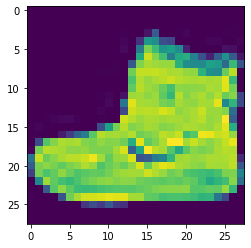

In [134]:
plt.imshow(train_dataset.data[0])
train_dataset.data[0].shape
train_dataset.classes[0]

In [133]:
from PIL import Image
model = torch.load('myAlexNet.pth')
transform=torchvision.transforms.Compose(
            [torchvision.transforms.Grayscale(),
            torchvision.transforms.Resize((224,224)),
            torchvision.transforms.ToTensor(),]
        )
img = Image.open('xxx.jpg')
print(type(img))
img = transform(img)
img = img.unsqueeze(0)
ans = predict(img, model, device)
label = classes[ans]
print('prediction of this image is : {}'.format(label))

<class 'PIL.JpegImagePlugin.JpegImageFile'>
prediction of this image is : Shirt
